In [1]:
import spiceypy
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Load kernels using the kernel_meta.txt file
spiceypy.furnsh("kernel_meta.txt")

In [2]:
# Datetime onject for the start
init_time_utc = datetime.datetime(year=2000, month=1, day=1, hour=0, minute=0, second=0)

# Number of days to calculate
delta_days = 10000

# Initial datetime object with added data
end_time_utc = init_time_utc + datetime.timedelta(days=delta_days)

In [3]:
# Convert datetime objects to strings
init_time_utc_str = init_time_utc.strftime("%Y-%m-%dT%H:%M:%S")
end_time_utc_str = end_time_utc.strftime("%Y-%m-%dT%H:%M:%S")

In [4]:
# Convert UTC datetime to ephemeris time
init_time_et = spiceypy.utc2et(init_time_utc_str)
end_time_et = spiceypy.utc2et(end_time_utc_str)

# Create an array between the two dates with the number of steps being the delta days
time_interval_et = np.linspace(start=init_time_et, stop=end_time_et, num=delta_days)

In [5]:
_, radii_sun = spiceypy.bodvcd(bodyid=10, item="RADII", maxn=3)

# radii_sun is an array with 3 entries
# retrieve first entry from array for the radius

radius_sun = radii_sun[0]

In [6]:
# Create an empty pandas DataFrame
solar_system_df = pd.DataFrame()

# Add an array of ephemeris time
solar_system_df.loc[:, "ET"] = time_interval_et

# Add UTC times by converting from ET to UTC
# Specify only the data, not the datatime
solar_system_df.loc[:, "UTC"] = solar_system_df["ET"].apply(
    lambda x: spiceypy.et2datetime(et=x).date()
)

# Add the position of the barycenter with respect to the sun
solar_system_df.loc[:, "POS_SSB_WRT_SUN"] = solar_system_df["ET"].apply(
    lambda x: spiceypy.spkgps(targ=0, et=x, ref="ECLIPJ2000", obs=10)[0]
)

# Normalize the position of the barycenter to the radius of the sun
solar_system_df.loc[:, "POS_SSB_WRT_SUN_SCALED"] = solar_system_df[
    "POS_SSB_WRT_SUN"
].apply(lambda x: x / radius_sun)

# Calculate distance of barycenter from sun
solar_system_df.loc[:, "SSB_WRT_SUN_SCALED_DIST"] = solar_system_df[
    "POS_SSB_WRT_SUN_SCALED"
].apply(lambda x: spiceypy.vnorm(x))

In [7]:
# Create a dictionary of the planet IDs associated with the given planet
# NAIF_ID_DICT = {"JUP": 5, "SAT": 6, "URA":7, "NEP":8}
NAIF_ID_DICT = {
    "JUP": 5,
    "SAT": 6,
}

for planet_name_key in NAIF_ID_DICT:
    planet_pos_col = f"POS_{planet_name_key}_WRT_SUN"
    planet_angle_col = f"PHASE_ANGLE_SUN_{planet_name_key}2SSB"

    planet_id = NAIF_ID_DICT[planet_name_key]

    # Add the position of the planet with respect to the sun
    solar_system_df.loc[:, planet_pos_col] = solar_system_df["ET"].apply(
        lambda x: spiceypy.spkgps(targ=planet_id, et=x, ref="ECLIPJ2000", obs=10)[0]
    )
    # Calculate the phase angle of the planets from the barycenter
    # Use np.degrees to convert it from radians
    # Specify a single axis for the appropriate data
    solar_system_df.loc[:, planet_angle_col] = solar_system_df.apply(
        lambda x: np.degrees(spiceypy.vsep(x[planet_pos_col], x["POS_SSB_WRT_SUN"])),
        axis=1,
    )

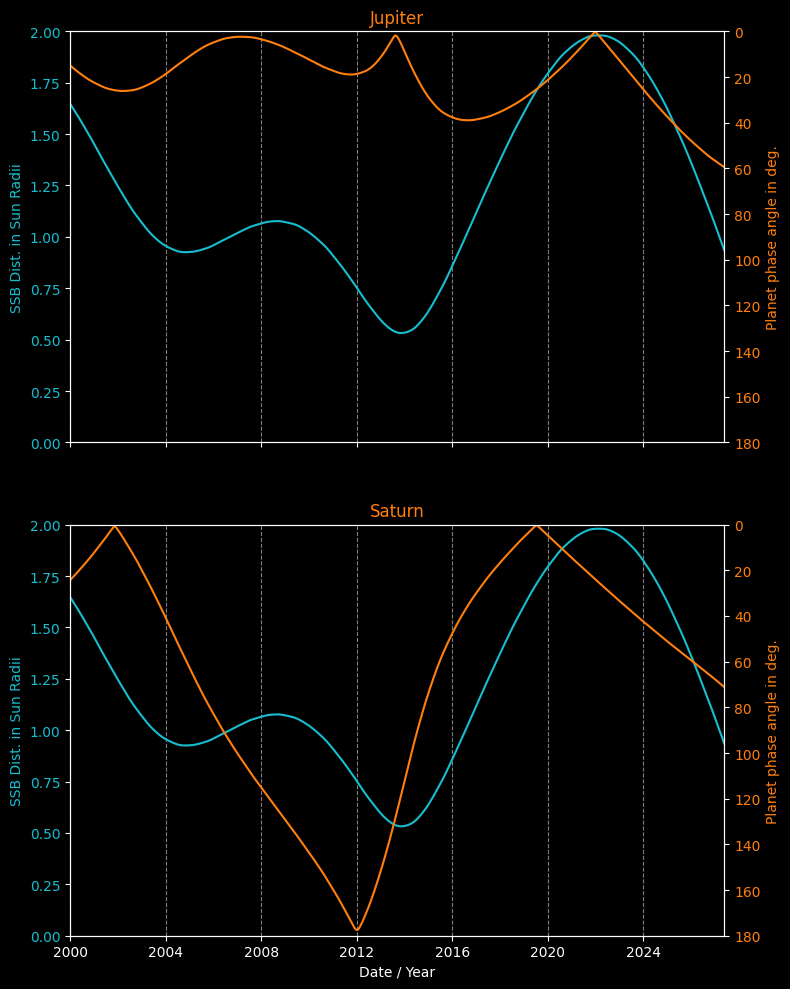

In [8]:
plt.style.use("dark_background")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 10))

for ax_f, planet_abr, planet_name in zip(
    [ax1, ax2], ["JUP", "SAT"], ["Jupiter", "Saturn"]
):
    ax_f.set_title(planet_name, color="tab:orange")
    ax_f.plot(
        solar_system_df["UTC"],
        solar_system_df["SSB_WRT_SUN_SCALED_DIST"],
        color="tab:cyan",
    )

    # Add label for y-axis
    ax_f.set_ylabel("SSB Dist. in Sun Radii", color="tab:cyan")
    # Set the color for the y-axis ticks to cyan
    ax_f.tick_params(axis="y", labelcolor="tab:cyan")

    # Change the x-axis limits to the min and max of the data
    ax_f.set_xlim(min(solar_system_df["UTC"]), max(solar_system_df["UTC"]))
    # Change the y-axis limits to the min and max of the solar radii
    ax_f.set_ylim(0, 2)

    # Create a second plot on top of the previous chart
    # Use .twinx() method to copy x-axis
    ax_f_add = ax_f.twinx()
    # Plot the phase angles of the given planet
    ax_f_add.plot(
        solar_system_df["UTC"],
        solar_system_df[f"PHASE_ANGLE_SUN_{planet_abr}2SSB"],
        color="tab:orange",
    )

    # Add a label on the right side of the figure for the phase angle
    ax_f_add.set_ylabel("Planet phase angle in deg.", color="tab:orange")
    ax_f_add.tick_params(axis="y", labelcolor="tab:orange")

    # Invert the y-axis
    ax_f_add.invert_yaxis()
    # Set the axis that the lowest (0-degrees) is at the top
    ax_f_add.set_ylim(180,0)

    # Add grid lines along the x-axis
    ax_f.grid(axis="x", linestyle="dashed", alpha=0.5)

ax2.set_xlabel("Date / Year")

fig.tight_layout()

plt.subplots_adjust(hspace=0.2)